# Φ-Mamba Quick Start Guide

This notebook demonstrates the key concepts of phase-locked language modeling with golden ratio encoding.

## 1. The Golden Ratio Foundation

Everything starts with φ as the primitive:

In [1]:
import numpy as np
from math import sqrt, log, pi
import matplotlib.pyplot as plt

# The golden ratio
PHI = (1 + sqrt(5)) / 2
PSI = -1 / PHI

print(f"φ = {PHI:.10f}")
print(f"ψ = {PSI:.10f}")
print(f"\nKey identity: φ² - φ = {PHI**2 - PHI:.10f} = 1")
print(f"This means unity (1) emerges from φ!")

φ = 1.6180339887
ψ = -0.6180339887

Key identity: φ² - φ = 1.0000000000 = 1
This means unity (1) emerges from φ!


## 2. Multiplication Becomes Addition

The key computational advantage:

In [2]:
# Traditional multiplication
a = PHI**5
b = PHI**3
traditional_result = a * b

# Φ-Mamba: just add exponents!
phi_result = PHI**(5 + 3)

print(f"Traditional: {a:.4f} × {b:.4f} = {traditional_result:.4f}")
print(f"Φ-Mamba:     φ⁵ × φ³ = φ⁸ = {phi_result:.4f}")
print(f"Same result: {abs(traditional_result - phi_result) < 1e-10}")
print(f"\nBut Φ-Mamba only used addition: 5 + 3 = 8!")

Traditional: 11.0902 × 4.2361 = 46.9787
Φ-Mamba:     φ⁵ × φ³ = φ⁸ = 46.9787
Same result: True

But Φ-Mamba only used addition: 5 + 3 = 8!


## 3. Zeckendorf Decomposition - Emergent Topology

Every number has a unique representation as non-adjacent Fibonacci numbers:

In [2]:
def fibonacci(n):
    if n <= 0: return 0
    if n == 1: return 1
    a, b = 0, 1
    for _ in range(2, n+1):
        a, b = b, a + b
    return b

def zeckendorf(n):
    if n == 0: return []
    
    # Build Fibonacci sequence
    fibs = []
    i = 2
    while fibonacci(i) <= n:
        fibs.append(fibonacci(i))
        i += 1
    
    # Greedy decomposition
    result = []
    for f in reversed(fibs):
        if f <= n:
            result.append(f)
            n -= f
            fibs.remove(f)
            # Remove next Fibonacci (gap constraint)
            if fibs and fibs[-1] < f:
                fibs = [x for x in fibs if x < f/1.5]
    
    return result

# Examples
for n in [10, 17, 25, 42]:
    zeck = zeckendorf(n)
    print(f"{n} = {' + '.join(map(str, zeck))}")
    
print("\nNotice: No consecutive Fibonacci numbers!")
print("This gap emerges from φ² = φ + 1")

10 = 8 + 2
17 = 13 + 3 + 1
25 = 21 + 3 + 1
42 = 34 + 8

Notice: No consecutive Fibonacci numbers!
This gap emerges from φ² = φ + 1


## 4. Token States on the Cylinder

Each token lives at a position on a cylinder:

In [3]:
class TokenState:
    def __init__(self, token, position):
        self.token = token
        self.position = position
        
        # Angular position (based on token hash)
        self.theta = 2 * pi * (hash(token) % 1000) / 1000
        
        # Energy decays with position
        self.energy = PHI**(-position)
        
        # Zeckendorf shells
        self.shells = zeckendorf(position + 1)
        
    def __repr__(self):
        return f"Token('{self.token}', pos={self.position}, energy={self.energy:.4f})"

# Create a sequence
sentence = "The cat sat"
tokens = sentence.split()
states = [TokenState(token, i) for i, token in enumerate(tokens)]

for state in states:
    print(state)
    
print(f"\nNotice energy decay: {states[0].energy:.4f} → {states[-1].energy:.4f}")

Token('The', pos=0, energy=1.0000)
Token('cat', pos=1, energy=0.6180)
Token('sat', pos=2, energy=0.3820)

Notice energy decay: 1.0000 → 0.3820


## 5. Natural Termination via Energy Decay

Sentences end naturally when energy depletes:

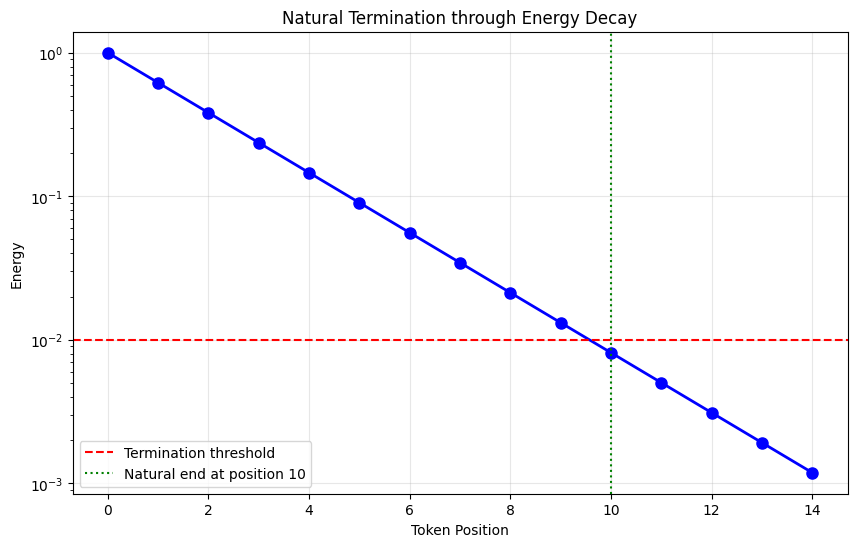

No arbitrary cutoff needed - physics determines sentence length!


In [4]:
# Show energy decay
positions = range(15)
energies = [PHI**(-p) for p in positions]

plt.figure(figsize=(10, 6))
plt.plot(positions, energies, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=0.01, color='r', linestyle='--', label='Termination threshold')
plt.xlabel('Token Position')
plt.ylabel('Energy')
plt.title('Natural Termination through Energy Decay')
plt.grid(True, alpha=0.3)
plt.legend()
plt.yscale('log')

# Find termination point
for i, e in enumerate(energies):
    if e < 0.01:
        plt.axvline(x=i, color='g', linestyle=':', label=f'Natural end at position {i}')
        break

plt.legend()
plt.show()

print("No arbitrary cutoff needed - physics determines sentence length!")

## 6. Phase Locking for Coherence

Coherent sequences have Berry phase ≈ 0 (mod 2π):

In [5]:
def berry_phase(state1, state2):
    """Calculate Berry phase between states"""
    d_theta = state2.theta - state1.theta
    
    # Shell overlap
    overlap = len(set(state1.shells) & set(state2.shells))
    max_shells = max(len(state1.shells), len(state2.shells), 1)
    
    gamma = d_theta * (1 + overlap/max_shells)
    return gamma % (2*pi)

def is_phase_locked(gamma, tolerance=0.5):
    """Check if phase indicates coherent transition"""
    return gamma < tolerance or gamma > (2*pi - tolerance)

# Check phase relationships in our sentence
print("Phase relationships:")
for i in range(len(states)-1):
    gamma = berry_phase(states[i], states[i+1])
    locked = is_phase_locked(gamma)
    status = "✓ LOCKED" if locked else "✗ not locked"
    print(f"{states[i].token} → {states[i+1].token}: γ = {gamma:.3f} {status}")

Phase relationships:
The → cat: γ = 2.997 ✗ not locked
cat → sat: γ = 5.925 ✓ LOCKED


## 7. Retrocausal Encoding

Future tokens constrain past tokens:

In [6]:
def retrocausal_encode(tokens):
    """Encode with future constraints"""
    # Create states
    states = [TokenState(token, i) for i, token in enumerate(tokens)]
    
    # Work backward
    for i in range(len(states)-1, 0, -1):
        future = states[i]
        past = states[i-1]
        
        # Future constrains past
        constraint = berry_phase(past, future)
        
        # Adjust past state based on future
        if is_phase_locked(constraint):
            past.coherence = 1.5  # Boost
        else:
            past.coherence = 0.5  # Reduce
            
    return states

# Compare forward vs retrocausal
forward_states = [TokenState(token, i) for i, token in enumerate(tokens)]
retro_states = retrocausal_encode(tokens)

print("Retrocausal encoding adds future information:")
for i, (f, r) in enumerate(zip(forward_states, retro_states)):
    coherence = getattr(r, 'coherence', 1.0)
    print(f"Position {i}: '{f.token}' coherence = {coherence}")

Retrocausal encoding adds future information:
Position 0: 'The' coherence = 0.5
Position 1: 'cat' coherence = 1.5
Position 2: 'sat' coherence = 1.0


## 8. Key Insights

1. **Unity emerges**: 1 = φ² - φ (not primitive)
2. **Addition only**: All multiplication → addition in log space 
3. **Natural boundaries**: Energy decay creates sentence endings
4. **Phase coherence**: Berry phase ensures meaningful sequences
5. **Retrocausal**: Future constrains past for better coherence
6. **Topology**: Information stored as hole patterns, not bits

This is a fundamentally different approach to language modeling!